In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('titanic.csv', index_col='PassengerId')
df.drop(columns=['Name','Ticket','Cabin'], inplace=True)
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
6,0,3,male,NaN,0,0,8.4583,Q
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.0750,S
9,1,3,female,27.0,0,2,11.1333,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [5]:
df.dropna(axis=0, how='any')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


### Exploratory Data Analysis

#### Target

In [7]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Numeric vs target

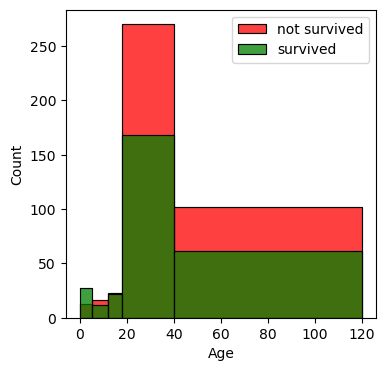

In [8]:
plt.figure(figsize=(4,4))
sns.histplot(df['Age'][df['Survived'] == 0], bins=[0,5,12,18,40,120], label='not survived', color='r')
sns.histplot(df['Age'][df['Survived'] == 1], bins=[0,5,12,18,40,120], label='survived', color='g')
plt.legend()

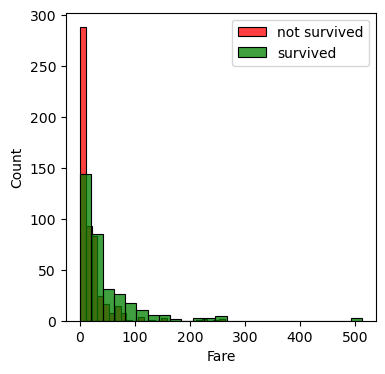

In [9]:
plt.figure(figsize=(4,4))
sns.histplot(df['Fare'][df['Survived'] == 0], bins=25, label='not survived', color='r')
sns.histplot(df['Fare'][df['Survived'] == 1], bins=25, label='survived', color='g')
plt.legend()

#### Categoric / ordinal vs target

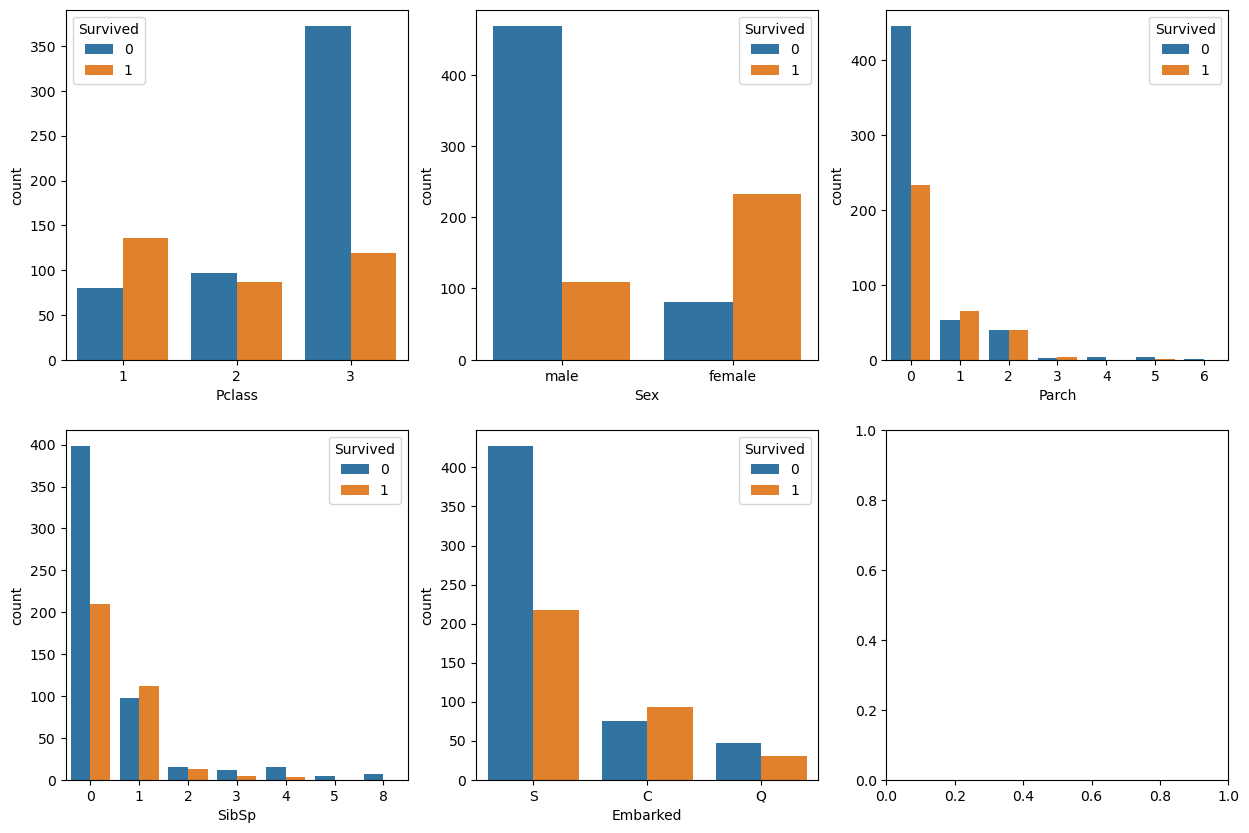

In [10]:
cat_var = ['Pclass', 'Sex', 'Parch', 'SibSp', 'Embarked']

fig, axes = plt.subplots(2,3, figsize=(15,10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, hue='Survived', ax=ax)

#### Dataset spliting

In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

from jcopml.tuning import grid_search_params as gsp

In [12]:
X = df.drop(columns=['Survived','Age'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 6), (179, 6), (712,), (179,))

In [13]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

#### Data preprocessing

In [14]:
numerical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ['Fare', 'SibSp', 'Parch']),
    ('categoric', categorical_pipeline, ['Pclass', 'Sex', 'Embarked'])
])

#### Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 0.01, 'algo__fit_intercept': False}
0.8160112359550562 0.8160065714049333 0.7932960893854749


#### Evaluation

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
y_pred = model.predict(X_test)

classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.77      0.95      0.85       110\n           1       0.86      0.55      0.67        69\n\n    accuracy                           0.79       179\n   macro avg       0.82      0.75      0.76       179\nweighted avg       0.81      0.79      0.78       179\n'

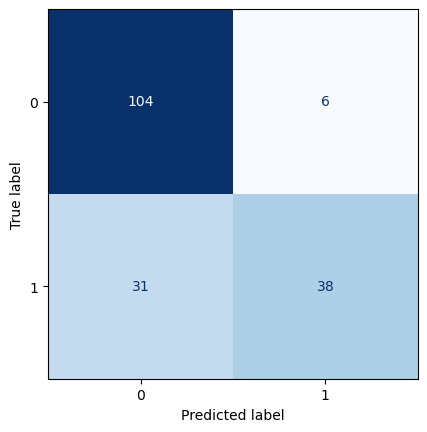

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',colorbar=False)

#### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 19, 'algo__p': 1, 'algo__weights': 'uniform'}
0.8188202247191011 0.8146060111808436 0.7877094972067039


#### Evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [23]:
y_pred = model.predict(X_test)

classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.78      0.92      0.84       110\n           1       0.82      0.58      0.68        69\n\n    accuracy                           0.79       179\n   macro avg       0.80      0.75      0.76       179\nweighted avg       0.79      0.79      0.78       179\n'

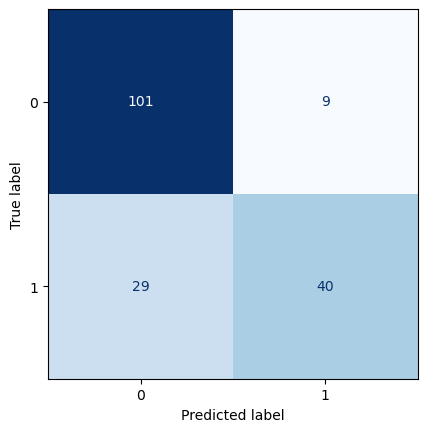

In [24]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',colorbar=False)

#### Random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier())
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 100}
0.8160112359550562 0.8103984209717643 0.7988826815642458


#### Evaluation

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [32]:
y_pred = model.predict(X_test)

In [33]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.78      0.95      0.85       110\n           1       0.87      0.57      0.68        69\n\n    accuracy                           0.80       179\n   macro avg       0.82      0.76      0.77       179\nweighted avg       0.81      0.80      0.79       179\n'

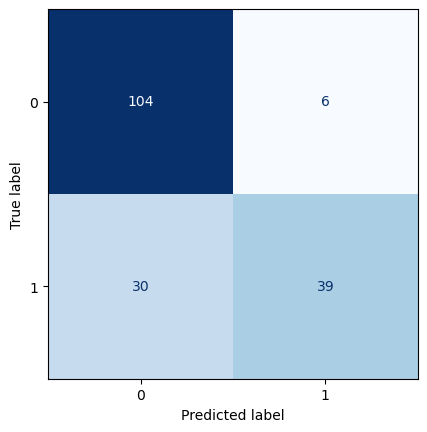

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',colorbar=False)

#### XGBosst

In [35]:
from xgboost import XGBClassifier

In [36]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier())
])

model = GridSearchCV(pipeline, gsp.xgb_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
{'algo__colsample_bytree': 0.6, 'algo__gamma': 1, 'algo__learning_rate': 0.1, 'algo__max_depth': 6, 'algo__n_estimators': 200, 'algo__reg_alpha': 0.01, 'algo__reg_lambda': 0.1, 'algo__subsample': 0.6}
0.8862359550561798 0.8174366793130755 0.776536312849162


#### Evaluation

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [38]:
y_pred = model.predict(X_test)

In [39]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.81      0.83      0.82       110\n           1       0.72      0.70      0.71        69\n\n    accuracy                           0.78       179\n   macro avg       0.76      0.76      0.76       179\nweighted avg       0.78      0.78      0.78       179\n'

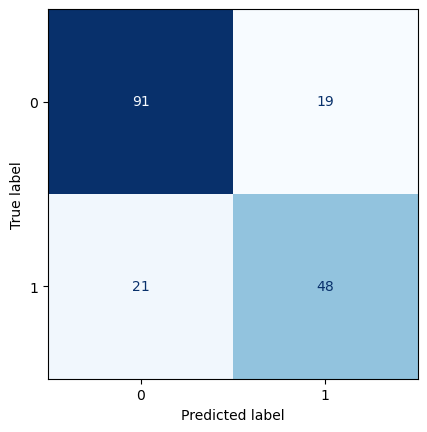

In [40]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',colorbar=False)

### Save best model

In [41]:
from jcopml.utils import save_model

save_model(model.best_estimator_, "XGB_model.pkl")

Model is pickled as model/XGB_model.pkl
